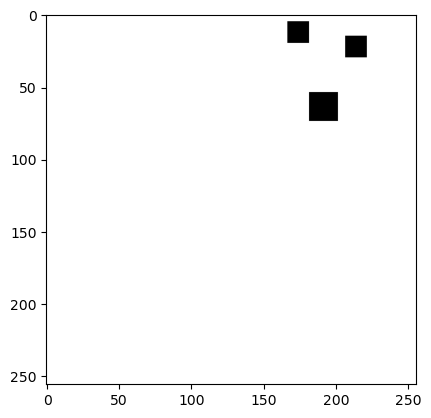

torch.Size([3, 256, 256])


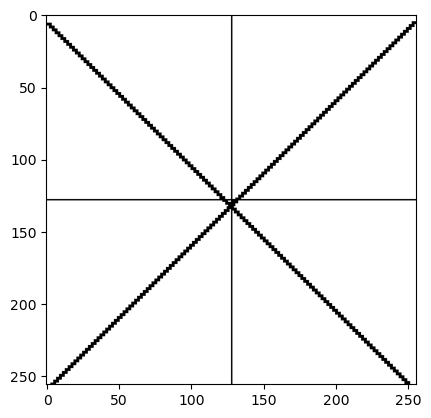

torch.Size([3, 256, 256])


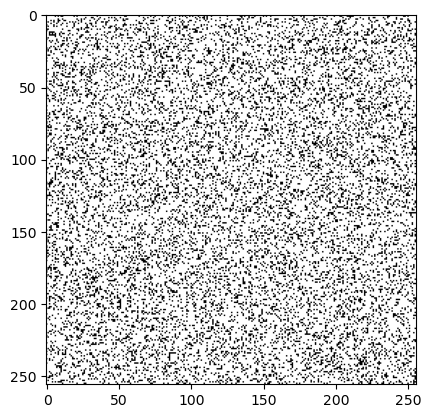

float64
torch.Size([3, 256, 256])
torch.float64


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch


# 1. three missing blocks
size = 20
mask = np.ones((256, 256, 3), dtype=int)
# Create 3 missing blocks
mask[64-size//2:64+size//2, 192-size//2:192+size//2, :] = 0 # center missing
mask[0+5:size, 177-size//2:172+size//2, :] = 0 # top left missing
mask[0+15:size+10, 217-size//2:212+size//2, :] = 0 # top rightt missing
plt.imshow(mask/1, cmap='gray') #plt.colorbar()
plt.show()
mask = torch.tensor(mask).permute(2,0,1)
print(mask.shape)

# 2. zigzagged lines of missing data
size = 256
mask = np.ones((size, size, 3), dtype=int)
# Create a zigzagged diagonal line
line_index = size // 2
mask[line_index] = 0 # Set the entire row to zero
mask[:, line_index] = 0 # Set the entire column to zero
for i in range(size): # Set the diagonal elements to zero with a zigzag pattern
    if i % 2 == 0: mask[i+4:i+6, i-2:i+2] = 0 # main diagonal
    else: mask[i+4:i+6, size-i-2:size-i+2] = 0 # other diagonal
plt.imshow(mask/1, cmap='gray') #plt.colorbar()
plt.show()
mask = torch.tensor(mask).permute(2,0,1)
print(mask.shape)


# 3. Parameters for a 3D mask of randomly distributed values
zero_fraction = 0.2              # Proportion of zeros in the array
mask_3d = np.random.choice([0, 1], size=(256, 256), p=[zero_fraction, 1-zero_fraction])
mask = np.zeros((256,256,3)); mask[:,:,0]=mask_3d; mask[:,:,1]=mask_3d; mask[:,:,2]=mask_3d
plt.imshow(mask/1, cmap='gray') #plt.colorbar()
plt.show()
print(mask.dtype)
mask = torch.tensor(mask).permute(2,0,1)
print(mask.shape)

test = torch.ones_like(mask)
print(mask.dtype)

In [1]:
import IPython.display
import torch
import MLexemplar
import numpy as np
from criminisi_mod import inpaint
from matplotlib import pyplot as plt
from model_tanimutomo import PConvUNet
from pytorch3d.transforms import euler_angles_to_matrix, so3_relative_angle
from scipy import ndimage
from tqdm.notebook import tqdm

In [2]:
model = PConvUNet(False)
state_dict = torch.load('epoch_486.pt', map_location='cpu')
model.load_state_dict(state_dict)
model.eval();

In [33]:
original: torch.Tensor = torch.load('/mnt/home/atindaea/synthetic_EBSD_data/val/8370_noisy.pt', map_location='cpu') / 360
mask = torch.ones_like(original)
mask[:, 64-20//2:64+20//2,192-20//2:192+20//2] = 0
# mask[:, 118:138, 118:138] = 0
mask = 1 - (1 - mask) * (torch.rand_like(mask[0]) > 0)
print(mask.shape)
print(mask.dtype)
damaged = original.clone()
damaged[mask == 0] = 0
original = original.permute(1, 2, 0).numpy()
damaged = damaged.permute(1, 2, 0).numpy()
mask = mask.permute(1, 2, 0).numpy()
mask.shape

torch.Size([3, 256, 256])
torch.float32


(256, 256, 3)

In [34]:
prediction = MLexemplar.single_predict(damaged, mask, model)
combined = damaged.copy()
combined[mask == 0] = prediction[mask == 0]

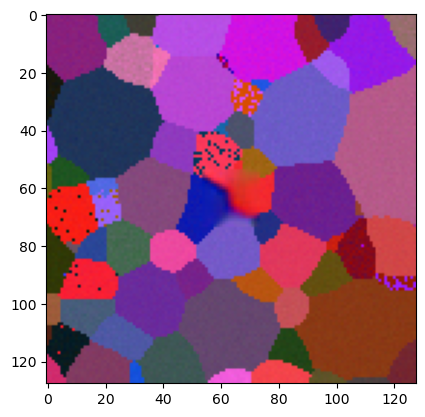

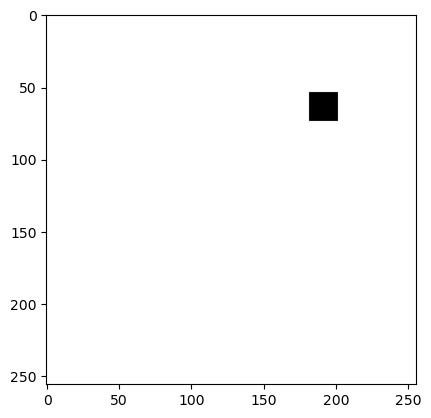

In [36]:
plt.imshow(np.clip(combined[:128, 128:, :], 0, 1));plt.show()
plt.imshow(mask)

clean: torch.Tensor = torch.load('/mnt/home/atindaea/synthetic_EBSD_data/val/8370_noisy.pt', map_location='cpu') / 360


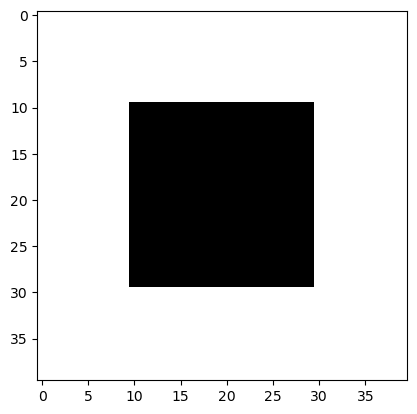

In [8]:
plt.imshow(mask[108:148, 108:148])

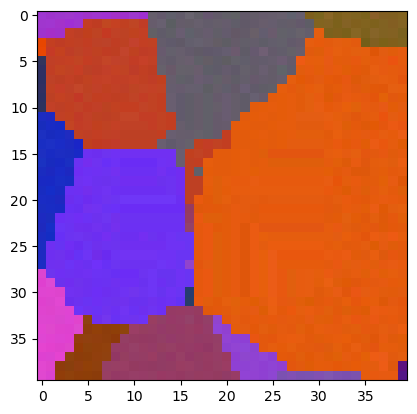

In [9]:
hybrid = inpaint(combined, ~mask.astype(bool), True, euclidean_penalty=1, known_weight=0)
plt.imshow(hybrid[108:148, 108:148])

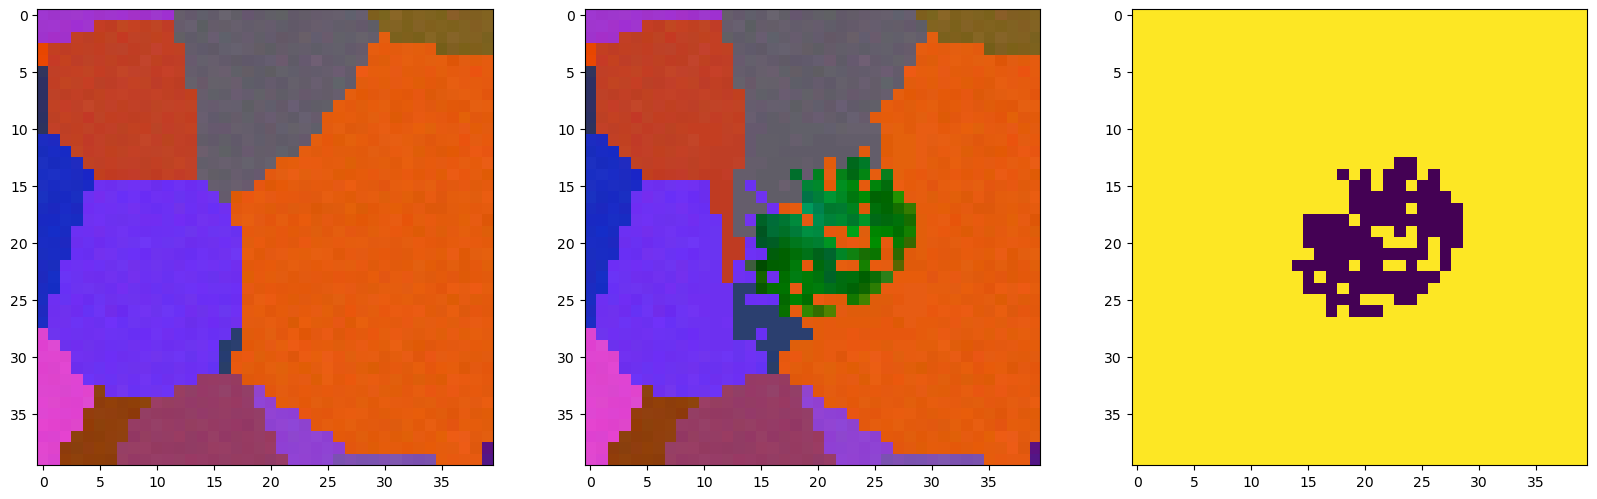

KeyboardInterrupt: 

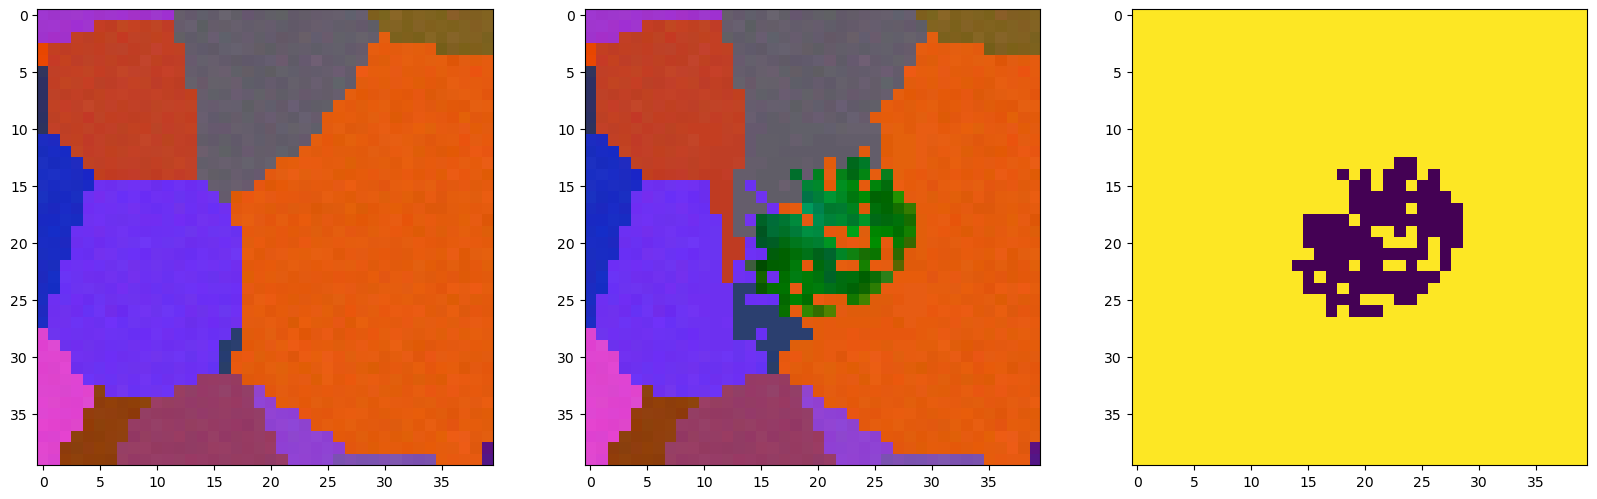

In [37]:
refined = combined.copy()
structuring_element = np.array([[0, 1, 0],
                                [1, 1, 1],
                                [0, 1, 0]])
with torch.no_grad():
    # known_boundary = ndimage.binary_dilation(
    #             1-mask[:, :, 0], structuring_element) * mask[:, :, 0]
    # source_euler_angles = damaged[known_boundary.nonzero()]
    # source_matrices = euler_angles_to_matrix(torch.tensor(source_euler_angles), 'ZXZ')

    working_mask = mask.copy()
    if working_mask.ndim == 3:
        working_mask = working_mask[:, :, 0]
    # progress_bar = tqdm(total=round((1-working_mask).sum()), desc='Refining image')
    fig, axs = plt.subplots(1, 3, figsize=(20, 20))
    axs[0].imshow(original[108:148, 108:148]);
    axs[1].imshow(np.clip(refined[108:148, 108:148], 0, 1));
    axs[2].imshow(working_mask[108:148, 108:148]);
    display_handle = IPython.display.display(fig)
    i = 0
    while not np.all(working_mask):
        unknown_boundary = ndimage.binary_dilation(
            working_mask, structuring_element) * (1-working_mask)
        unknown_boundary_indexes = list(zip(*unknown_boundary.nonzero()))
        lowest_difference = torch.finfo(torch.float32).max
        lowest_difference_index = None
        lowest_difference_euler_angles = None
        for index in unknown_boundary_indexes:
            target_matrix = euler_angles_to_matrix(torch.tensor([combined[index]]), 'ZXZ')[0]
            for adjacent_index in [(index[0]-1, index[1]),
                                   (index[0], index[1]-1),
                                   (index[0]+1, index[1]),
                                   (index[0], index[1]+1)]:
                if (adjacent_index[0] >= 0 and adjacent_index[0] < 256
                    and adjacent_index[1] >= 0 and adjacent_index[1] < 256
                    and working_mask[adjacent_index] == 1):
                    source_matrix = euler_angles_to_matrix(torch.tensor([refined[adjacent_index]]), 'ZXZ')[0]
                    difference = so3_relative_angle(target_matrix.unsqueeze(0), source_matrix.unsqueeze(0))
                    if difference < lowest_difference:
                        lowest_difference = difference
                        lowest_difference_index = index
                        lowest_difference_euler_angles = refined[adjacent_index]
        refined[lowest_difference_index] = lowest_difference_euler_angles
        working_mask[lowest_difference_index] = 1
        # progress_bar.update()
        if i % 10 == 0:
            axs[0].imshow(original[108:148, 108:148]);
            axs[1].imshow(np.clip(refined[108:148, 108:148], 0, 1));
            axs[2].imshow(working_mask[108:148, 108:148]);
            IPython.display.display(fig, clear=True)
        i += 1

IPython.display.clear_output()
axs[0].imshow(original[108:148, 108:148]);
axs[1].imshow(np.clip(refined[108:148, 108:148], 0, 1));
axs[2].imshow(working_mask[108:148, 108:148]);

    # for i in range(118, 138):
    #     for j in range(118, 138):
    #         target_euler_angles = combined[i, j]
    #         target_matrix = euler_angles_to_matrix(torch.tensor([target_euler_angles]), 'ZXZ')[0]
    #         target_matrix_repeated = target_matrix.repeat(len(source_matrices), 1, 1)
    #         distances = so3_relative_angle(source_matrices, target_matrix_repeated)
    #         refined[i, j] = source_euler_angles[torch.argmin(distances)]